In [1]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
#Can be very helpful to notice any imbalance in classes
from collections import Counter


try:
    conn = psycopg2.connect(database="group_26", user="ywang657", password="", host="www.eecs.uottawa.ca", port="15432")

    print ("Opened database successfully")
    cursor = conn.cursor()
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Opened database successfully


In [2]:
#选择preprocess的数据
try:
    #Lets get our data
    cursor.execute("SELECT week_in_year,age_group, client_gender, case_acquisitioninfo, rain_mm, snow_cm,\
                   status_phu, isresolved, isfatal from fact_table as fact inner join patient_dimension as patient\
                   on fact.patient_key = patient.surrogate_key inner join weather_dimension\
                   as weather on fact.weather_key=weather.surrogate_key inner join special_measures_dimension as special on fact.special_measures_key=special.surrogate_key\
                   inner join date_dimension as dated on fact.onset_date_key=dated.surrogate_key"
                  )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()

except (Exception, psycopg2.DatabaseError) as error:
    print(error)


In [3]:
result_df = pd.DataFrame(result_list, columns=["week_in_year","age_group", "client_gender",

                                               "case_acquisitioninfo","rain_mm","snow_cm","status_phu","isresolved","isfatal"])

In [4]:
result_df.head()

,week_in_year,age_group,client_gender,case_acquisitioninfo,rain_mm,snow_cm,status_phu,isresolved,isfatal
0,51,80s,FEMALE,CC,NaN,NaN,Lockdown,1,0
1,50,20s,MALE,NO KNOWN EPI LINK,NaN,NaN,Lockdown,1,0
2,51,30s,FEMALE,CC,0.0,0.0,Control,1,0
3,50,20s,MALE,NO KNOWN EPI LINK,NaN,NaN,Lockdown,1,0
4,50,20s,MALE,CC,NaN,NaN,Lockdown,1,0


<AxesSubplot:>

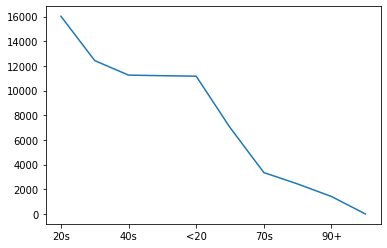

In [5]:
#Part A的第一部分，把数据plot出来
age=result_df.age_group.value_counts()
age.plot()

<AxesSubplot:>

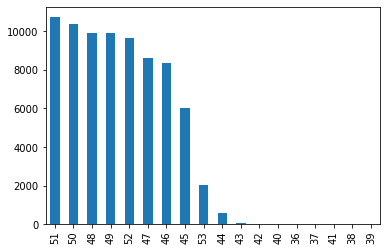

In [6]:
week=result_df.week_in_year.value_counts()
week.plot(kind='bar')

<AxesSubplot:>

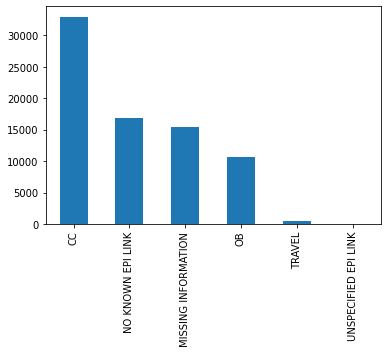

In [7]:
ca=result_df.case_acquisitioninfo.value_counts()
ca.plot(kind="bar")

<AxesSubplot:>

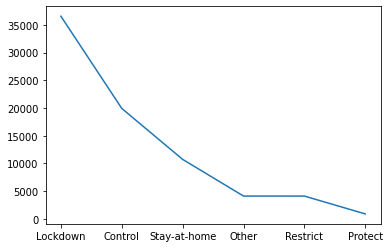

In [8]:
st=result_df.status_phu.value_counts()
st.plot()

In [9]:
result_df['rain_mm'].fillna(0.0, inplace=True)
result_df['snow_cm'].fillna(0.0, inplace=True)

In [10]:
result_df.head()

,week_in_year,age_group,client_gender,case_acquisitioninfo,rain_mm,snow_cm,status_phu,isresolved,isfatal
0,51,80s,FEMALE,CC,0.0,0.0,Lockdown,1,0
1,50,20s,MALE,NO KNOWN EPI LINK,0.0,0.0,Lockdown,1,0
2,51,30s,FEMALE,CC,0.0,0.0,Control,1,0
3,50,20s,MALE,NO KNOWN EPI LINK,0.0,0.0,Lockdown,1,0
4,50,20s,MALE,CC,0.0,0.0,Lockdown,1,0


<AxesSubplot:>

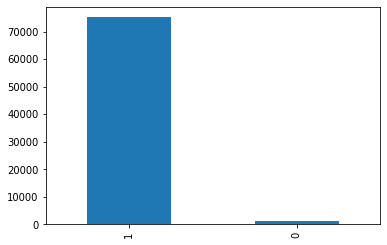

In [11]:
reso=result_df.isresolved.value_counts()
reso.plot(kind='bar')


<AxesSubplot:>

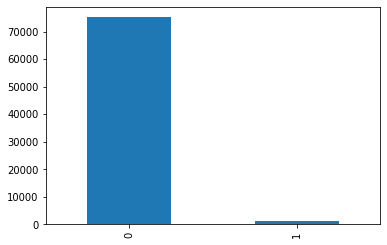

In [12]:
fat=result_df.isfatal.value_counts()
fat.plot(kind='bar')

In [13]:
resolved=Counter(result_df['isresolved'])
print(resolved)

Counter({1: 75163, 0: 1158})


In [14]:
fatal=Counter(result_df['isfatal'])
print(fatal)

Counter({0: 75177, 1: 1144})


In [15]:
# 这个部分做的 isresolved 和 is fatal 的 undersampling
no_frauds = len(result_df[result_df['isresolved'] == 0])
non_fraud_indices = result_df[result_df.isresolved == 1].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = result_df[result_df.isresolved == 0].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
result_df = result_df.loc[under_sample_indices]

no_frauds = len(result_df[result_df['isfatal'] == 1])
non_fraud_indices = result_df[result_df.isfatal == 0].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = result_df[result_df.isfatal== 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
result_df = result_df.loc[under_sample_indices]

In [16]:
y = result_df['isresolved']
#Drop the column for the next step
result_df.drop(columns=['isresolved'], inplace=True)
result_df.drop(columns=['isfatal'], inplace=True)

In [17]:
result_df.head()

,week_in_year,age_group,client_gender,case_acquisitioninfo,rain_mm,snow_cm,status_phu
36,51,80s,MALE,OB,0.0,0.0,Control
55,51,90+,MALE,OB,0.0,0.0,Lockdown
143,47,90+,MALE,OB,0.0,0.0,Restrict
315,51,70s,FEMALE,CC,0.0,0.0,Lockdown
356,51,90+,FEMALE,OB,0.0,0.0,Lockdown


In [18]:
#这个部分做的 one-hot-encoding
new_result_df = pd.get_dummies(result_df, prefix=[ "age_group","client_gender", "case_acquisitioninfo",
                                                  "status_phu"])
new_result_df["rain_mm"] = result_df["rain_mm"]
new_result_df["snow_cm"] = result_df["snow_cm"]
new_result_df["week_in_year"] = result_df["week_in_year"]
#Get the X values
X = new_result_df.values
new_result_df.head()

,week_in_year,rain_mm,snow_cm,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,...,case_acquisitioninfo_MISSING INFORMATION,case_acquisitioninfo_NO KNOWN EPI LINK,case_acquisitioninfo_OB,case_acquisitioninfo_TRAVEL,status_phu_Control,status_phu_Lockdown,status_phu_Other,status_phu_Protect,status_phu_Restrict,status_phu_Stay-at-home
36,51,0.0,0.0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
55,51,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
143,47,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
315,51,0.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
356,51,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [20]:
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({0: 926, 1: 904}) 
Test set Counter({0: 232, 1: 226}) 


In [21]:
dt = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
dt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

In [22]:
y_pred = dt.predict(X_test)
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100
accuracy= accuracy_score(y_pred, y_test) * 100
print("learning rate= 0.5")
print("Recall of Decision Tree {:.2f} %".format(recall))
print("precision of Decision Tree {:.2f} %".format(precision))
print("Accuracy of Decision Tree {:.2f} %".format(accuracy))



learning rate= 0.5
Recall of Decision Tree 88.50 %
precision of Decision Tree 88.50 %
Accuracy of Decision Tree 88.65 %
